# Linear Regression on AirBnB (log) Price


## Introduction

AirBnB is an internet marketplace where users can both rent and rent out accomodations. One of the biggest challenges of AirBnB is finding the right price per night to set an accomodation. In this project we will be looking at the factors that have the highest impact in order to estimate the price per night of an AirBnB rental in the five boroughs of New York City.

## Business Case

Since 2008, AirBnB has acted as an online retailer for short term rentals. There has been a great debate between whether or not short term rentals should be allowed and the aim of this project is to create a model that can predict price in order to entice landowners into renting out their property using AirBnB. 

## About our Data

Our data set was downloaded from http://tomslee.net/airbnb-data-collection-get-the-data

It contains the following elements:

- room_id: A unique number identifying an Airbnb listing. 

- host_id: A unique number identifying an Airbnb host. 

- room_type: One of “Entire home/apt”, “Private room”, or “Shared room”

- borough: A subregion of the city or search area for which the survey is carried out. The borough is taken from a shapefile of the city that is obtained independently of the Airbnb web site. For some cities, there is no borough information; for others the borough may be a number. If you have better shapefiles for a city of interest, please send them to me.

- neighborhood: As with borough: a subregion of the city or search area for which the survey is carried out. For cities that have both, a neighbourhood is smaller than a borough. For some cities there is no neighbourhood information.

- reviews: The number of reviews that a listing has received. Airbnb has said that 70% of visits end up with a review, so the number of reviews can be used to estimate the number of visits. Note that such an estimate will not be reliable for an individual listing (especially as reviews occasionally vanish from the site), but over a city as a whole it should be a useful metric of traffic.

- overall_satisfaction: The average rating (out of five) that the listing has received from those visitors who left a review.

- accommodates: The number of guests a listing can accommodate.

- bedrooms: The number of bedrooms a listing offers.

- price: The price (in US) for a night stay. In early surveys, there may be some values that were recorded by month.

- minstay: The minimum stay for a visit, as posted by the host.

- latitude and longitude: The latitude and longitude of the listing as posted on the Airbnb site: this may be off by a few hundred metres. I do not have a way to track individual listing locations with

- last_modified: the date and time that the values were read from the Airbnb web site.


In [1]:
# Import packages
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lars_path
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score
import scipy.stats as stats
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import our data
df = pd.read_csv('tomslee_airbnb_new_york_1438_2017-07-12.csv')

In [3]:
# find column names and data types
df.dtypes

room_id                   int64
survey_id                 int64
host_id                   int64
room_type                object
country                 float64
city                     object
borough                  object
neighborhood             object
reviews                   int64
overall_satisfaction    float64
accommodates              int64
bedrooms                float64
bathrooms               float64
price                   float64
minstay                 float64
name                     object
property_type            object
last_modified            object
latitude                float64
longitude               float64
location                 object
dtype: object

# Investigate Dataset

In [4]:
# Preview Dataset

df.head(5)

,room_id,survey_id,host_id,room_type,country,city,borough,neighborhood,reviews,overall_satisfaction,...,bedrooms,bathrooms,price,minstay,name,property_type,last_modified,latitude,longitude,location
0,7739955,1438,38614070,Shared room,NaN,New York,Queens,Jackson Heights,6,5.0,...,1.0,NaN,85.0,NaN,"Room TO SHARE by DAY,week,month",House,2017-07-15 21:30:31.858764,40.749909,-73.876880,0101000020E61000000EA14ACD1E7852C0F0FCA204FD5F...
1,7383173,1438,32628813,Shared room,NaN,New York,Brooklyn,Cypress Hills,14,4.0,...,1.0,NaN,90.0,NaN,Spacious Room: Close to Manhattan,House,2017-07-15 21:30:30.332828,40.678527,-73.889584,0101000020E6100000DFC2BAF1EE7852C0FC3905F9D956...
2,10250852,1438,35553123,Shared room,NaN,New York,Brooklyn,Sheepshead Bay,3,4.5,...,1.0,NaN,239.0,NaN,COZY COUCH,Apartment,2017-07-15 21:30:23.607950,40.583041,-73.957976,0101000020E61000009696917A4F7D52C0139D6516A14A...
3,2188359,1438,5029659,Shared room,NaN,New York,Manhattan,Hell's Kitchen,35,5.0,...,1.0,NaN,165.0,NaN,1 Bdrm Apt 1 Block from Times Sq.,Apartment,2017-07-15 21:30:21.832749,40.758374,-73.991955,0101000020E6100000A306D3307C7F52C0801134661261...
4,19661354,1438,70038324,Shared room,NaN,New York,Manhattan,Upper East Side,0,0.0,...,1.0,NaN,159.0,NaN,NYC Upper East / Midtown East Luxury 1BR,Apartment,2017-07-15 21:30:19.986579,40.761960,-73.959733,0101000020E610000016F9F5436C7D52C01A6EC0E78761...


In [5]:
# Descriptive Statistics of the data
df.describe()

,room_id,survey_id,host_id,country,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,minstay,latitude,longitude
count,4.124500e+04,41245.0,4.124500e+04,0.0,41245.000000,41245.000000,41245.000000,41245.000000,0.0,41245.000000,0.0,41245.000000,41245.000000
mean,1.097598e+07,1438.0,3.477635e+07,NaN,17.463571,2.735774,2.851982,1.162395,NaN,136.103528,NaN,40.731183,-73.954717
std,6.098062e+06,0.0,3.755800e+07,NaN,31.917262,2.336536,1.865672,0.763021,NaN,166.615958,NaN,0.054861,0.042493
min,2.515000e+03,1438.0,7.200000e+01,NaN,0.000000,0.000000,1.000000,0.000000,NaN,0.000000,NaN,40.508684,-74.239859
25%,5.806817e+06,1438.0,5.334697e+06,NaN,1.000000,0.000000,2.000000,1.000000,NaN,65.000000,NaN,40.691208,-73.983521
50%,1.179878e+07,1438.0,2.029277e+07,NaN,4.000000,4.500000,2.000000,1.000000,NaN,100.000000,NaN,40.725062,-73.956776
75%,1.633739e+07,1438.0,5.065631e+07,NaN,19.000000,5.000000,4.000000,1.000000,NaN,160.000000,NaN,40.765689,-73.939254
max,1.987405e+07,1438.0,1.405179e+08,NaN,454.000000,5.000000,16.000000,50.000000,NaN,9999.000000,NaN,40.908039,-73.702257


In [6]:
# Find number of data points for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41245 entries, 0 to 41244
Data columns (total 21 columns):
room_id                 41245 non-null int64
survey_id               41245 non-null int64
host_id                 41245 non-null int64
room_type               41245 non-null object
country                 0 non-null float64
city                    41245 non-null object
borough                 41245 non-null object
neighborhood            41245 non-null object
reviews                 41245 non-null int64
overall_satisfaction    41245 non-null float64
accommodates            41245 non-null int64
bedrooms                41245 non-null float64
bathrooms               0 non-null float64
price                   41245 non-null float64
minstay                 0 non-null float64
name                    41221 non-null object
property_type           41245 non-null object
last_modified           41245 non-null object
latitude                41245 non-null float64
longitude               412

# Data Wrangling


In [7]:
#Find null values
df.isnull().sum()

room_id                     0
survey_id                   0
host_id                     0
room_type                   0
country                 41245
city                        0
borough                     0
neighborhood                0
reviews                     0
overall_satisfaction        0
accommodates                0
bedrooms                    0
bathrooms               41245
price                       0
minstay                 41245
name                       24
property_type               0
last_modified               0
latitude                    0
longitude                   0
location                    0
dtype: int64

In [8]:
# Delete unnecessary data
del df['country']

In [9]:
del df['bathrooms']

In [10]:
del df['minstay']

In [11]:
del df['survey_id']

In [12]:
del df['location']

In [13]:
del df['name']

In [14]:
del df['last_modified']

In [15]:
# Delete data where there are no reviews as their overall score doesnt contribute 
df = df[df['reviews'] != 0]

In [16]:
# Remove data with 0 price information
df = df[df['price'] > 0]

In [17]:
df.dropna(inplace= True)

In [18]:
df.shape

(31384, 14)

In [19]:
# Descriptive Statistics of price
df.price.describe()

count    31384.00000
mean       131.04190
std        142.48892
min         10.00000
25%         65.00000
50%        100.00000
75%        159.00000
max       9999.00000
Name: price, dtype: float64

In [20]:
# Find values counts for different property types
df.property_type.value_counts()

Apartment             26482
House                  2904
Loft                    661
Townhouse               544
Condominium             340
Other                   135
Bed & Breakfast         124
Guesthouse               43
Timeshare                24
Hostel                   22
Guest suite              19
Villa                    17
Bungalow                 16
Dorm                     15
Boutique hotel           12
Boat                      4
Earth House               3
Castle                    3
Cabin                     3
Vacation home             3
Camper/RV                 2
Chalet                    2
Serviced apartment        2
In-law                    2
Cave                      1
Casa particular           1
Name: property_type, dtype: int64

In [21]:
# That will be a hassle for dummy values, lets aggregate the smaller values into 'Other'
series =pd.value_counts(df.property_type)
mask = (series/series.sum() *100).lt(1)
df['property_type'] = np.where(df['property_type'].isin(series[mask].index), 'Other', df['property_type'])

In [22]:
# Check that it worked
df.property_type.value_counts()

Apartment      26482
House           2904
Loft             661
Townhouse        544
Other            453
Condominium      340
Name: property_type, dtype: int64

In [23]:
# Check data for the 5 boroughs
df.borough.value_counts()

Manhattan        14649
Brooklyn         12808
Queens            3187
Bronx              532
Staten Island      208
Name: borough, dtype: int64

In [24]:
# Check value counts of room type
df.room_type.value_counts()

Entire home/apt    16269
Private room       14336
Shared room          779
Name: room_type, dtype: int64

In [25]:
(1080/41221)*100


2.6200237742898036

In [26]:
# As shared rooms only represent 2% of our dataset, we're going to drop those values
df = df[df['room_type'] != 'Shared room']

In [27]:
# Find top 10 Neighborhoods
top10_nb = df.neighborhood.value_counts().head(10)
print(top10_nb)

Williamsburg          2585
Bedford-Stuyvesant    2094
Harlem                1940
Bushwick              1392
Upper West Side       1385
East Village          1296
Hell's Kitchen        1234
Upper East Side       1173
Crown Heights         1011
Chelsea                826
Name: neighborhood, dtype: int64


In [28]:
top10nb_df = df[df['neighborhood'].isin(['Williamsburg', 'Bedford-Stuyvesant', 'Harlem', 'Bushwick', 'Upper West Side',
                                        'East Village', 'Hell\'s Kitchen', 'Upper East Side', 'Crown Heights', 'Chelsea'])]
top10nb_df


,room_id,host_id,room_type,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,property_type,latitude,longitude
1009,412180,2051961,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,6,4.5,4,1.0,95.0,Apartment,40.693212,-73.944198
1011,13388984,68700413,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,1,0.0,4,1.0,90.0,Apartment,40.685574,-73.948643
1013,13509935,21188208,Entire home/apt,New York,Manhattan,East Village,1,0.0,9,4.0,3497.0,Apartment,40.724882,-73.984570
1017,893413,4751930,Entire home/apt,New York,Manhattan,East Village,8,5.0,8,3.0,1550.0,Townhouse,40.726676,-73.981791
1027,8739642,44179601,Entire home/apt,New York,Manhattan,Chelsea,4,5.0,12,4.0,900.0,Apartment,40.744556,-73.992671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41226,15990572,103841276,Private room,New York,Brooklyn,Bushwick,31,4.5,2,1.0,35.0,Townhouse,40.699944,-73.932240
41227,2232697,1726966,Private room,New York,Brooklyn,Crown Heights,72,4.5,1,1.0,34.0,Apartment,40.671672,-73.924342
41228,16546347,106838618,Private room,New York,Brooklyn,Bedford-Stuyvesant,51,4.5,1,1.0,28.0,Apartment,40.680030,-73.910428
41230,7717598,40532977,Private room,New York,Brooklyn,Bedford-Stuyvesant,55,4.5,2,1.0,30.0,Apartment,40.679824,-73.913473


In [29]:
# Explore Correlations between top10 neighborhoods
top10nb_df.corr()['price'].sort_values()

longitude              -0.296998
room_id                -0.065932
host_id                -0.029458
reviews                -0.024628
overall_satisfaction    0.034026
latitude                0.113349
bedrooms                0.409443
accommodates            0.540479
price                   1.000000
Name: price, dtype: float64

In [30]:
top10nb_df.overall_satisfaction.value_counts()

5.0    5761
4.5    4883
0.0    3430
4.0     725
3.5     111
3.0      18
2.5       7
1.0       1
Name: overall_satisfaction, dtype: int64

In [31]:
df.overall_satisfaction.describe()

count    30605.000000
mean         3.592844
std          2.023752
min          0.000000
25%          4.000000
50%          4.500000
75%          5.000000
max          5.000000
Name: overall_satisfaction, dtype: float64

In [32]:
df.corr()['price'].sort_values()

longitude              -0.197157
room_id                -0.063815
host_id                -0.039098
reviews                -0.023842
overall_satisfaction    0.010995
latitude                0.030989
bedrooms                0.359862
accommodates            0.458835
price                   1.000000
Name: price, dtype: float64

In [33]:
# Place dummy data for for property type
dummy = pd.get_dummies(df['property_type'])
dummy.head()

,Apartment,Condominium,House,Loft,Other,Townhouse
1008,1,0,0,0,0,0
1009,1,0,0,0,0,0
1011,1,0,0,0,0,0
1013,1,0,0,0,0,0
1015,0,0,1,0,0,0


In [34]:
# Combine the dummy data with our main dataframe
df = pd.concat([df, dummy], axis =1)
df.head()

,room_id,host_id,room_type,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,price,property_type,latitude,longitude,Apartment,Condominium,House,Loft,Other,Townhouse
1008,18707757,130063429,Entire home/apt,New York,Brooklyn,East New York,6,4.0,6,1.0,113.0,Apartment,40.659736,-73.898677,1,0,0,0,0,0
1009,412180,2051961,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,6,4.5,4,1.0,95.0,Apartment,40.693212,-73.944198,1,0,0,0,0,0
1011,13388984,68700413,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,1,0.0,4,1.0,90.0,Apartment,40.685574,-73.948643,1,0,0,0,0,0
1013,13509935,21188208,Entire home/apt,New York,Manhattan,East Village,1,0.0,9,4.0,3497.0,Apartment,40.724882,-73.984570,1,0,0,0,0,0
1015,2953058,1177497,Entire home/apt,New York,Brooklyn,Clinton Hill,1,0.0,16,5.0,8000.0,House,40.691371,-73.967228,0,0,1,0,0,0


In [35]:
dummy3 = pd.get_dummies(df['borough'])
dummy3.head()

,Bronx,Brooklyn,Manhattan,Queens,Staten Island
1008,0,1,0,0,0
1009,0,1,0,0,0
1011,0,1,0,0,0
1013,0,0,1,0,0
1015,0,1,0,0,0


In [36]:
df = pd.concat([df, dummy3], axis =1)
df.head()

,room_id,host_id,room_type,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,...,Condominium,House,Loft,Other,Townhouse,Bronx,Brooklyn,Manhattan,Queens,Staten Island
1008,18707757,130063429,Entire home/apt,New York,Brooklyn,East New York,6,4.0,6,1.0,...,0,0,0,0,0,0,1,0,0,0
1009,412180,2051961,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,6,4.5,4,1.0,...,0,0,0,0,0,0,1,0,0,0
1011,13388984,68700413,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,1,0.0,4,1.0,...,0,0,0,0,0,0,1,0,0,0
1013,13509935,21188208,Entire home/apt,New York,Manhattan,East Village,1,0.0,9,4.0,...,0,0,0,0,0,0,0,1,0,0
1015,2953058,1177497,Entire home/apt,New York,Brooklyn,Clinton Hill,1,0.0,16,5.0,...,0,1,0,0,0,0,1,0,0,0


In [37]:
df.corr()['price'].sort_values()

longitude              -0.197157
Brooklyn               -0.112679
Queens                 -0.102196
room_id                -0.063815
Bronx                  -0.060032
Apartment              -0.041056
host_id                -0.039098
Staten Island          -0.025549
reviews                -0.023842
House                  -0.016561
Other                  -0.003149
overall_satisfaction    0.010995
latitude                0.030989
Townhouse               0.032188
Loft                    0.063340
Condominium             0.065133
Manhattan               0.192303
bedrooms                0.359862
accommodates            0.458835
price                   1.000000
Name: price, dtype: float64

In [38]:
dummy4 = pd.get_dummies(df['room_type'])
dummy4.head()

,Entire home/apt,Private room
1008,1,0
1009,1,0
1011,1,0
1013,1,0
1015,1,0


In [39]:
df = pd.concat([df, dummy4], axis =1)
df.head()

,room_id,host_id,room_type,city,borough,neighborhood,reviews,overall_satisfaction,accommodates,bedrooms,...,Loft,Other,Townhouse,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room
1008,18707757,130063429,Entire home/apt,New York,Brooklyn,East New York,6,4.0,6,1.0,...,0,0,0,0,1,0,0,0,1,0
1009,412180,2051961,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,6,4.5,4,1.0,...,0,0,0,0,1,0,0,0,1,0
1011,13388984,68700413,Entire home/apt,New York,Brooklyn,Bedford-Stuyvesant,1,0.0,4,1.0,...,0,0,0,0,1,0,0,0,1,0
1013,13509935,21188208,Entire home/apt,New York,Manhattan,East Village,1,0.0,9,4.0,...,0,0,0,0,0,1,0,0,1,0
1015,2953058,1177497,Entire home/apt,New York,Brooklyn,Clinton Hill,1,0.0,16,5.0,...,0,0,0,0,1,0,0,0,1,0


In [40]:
df.corr()['price'].sort_values()

Private room           -0.376005
longitude              -0.197157
Brooklyn               -0.112679
Queens                 -0.102196
room_id                -0.063815
Bronx                  -0.060032
Apartment              -0.041056
host_id                -0.039098
Staten Island          -0.025549
reviews                -0.023842
House                  -0.016561
Other                  -0.003149
overall_satisfaction    0.010995
latitude                0.030989
Townhouse               0.032188
Loft                    0.063340
Condominium             0.065133
Manhattan               0.192303
bedrooms                0.359862
Entire home/apt         0.376005
accommodates            0.458835
price                   1.000000
Name: price, dtype: float64

In [41]:
# Add a feature for logarithmic price
df['log_price'] = np.log(df['price'])

#Create variables for log_price mean and STD
lgpm = df.log_price.mean()
lgps = df.log_price.std()

In [42]:
# Exploration showed that data outside of two standard deviations didnt really tell us anything so we'll
# build the model data off of what it can show.
model_df = df[df['log_price'] >= lgpm - (2*lgps)]
model_df = df[df['log_price'] <= (2*lgps)+lgpm]

# Data Visualization

In [43]:
#sns.pairplot(df, diag_kind="kde", height=2.5)

Text(0, 0.5, 'Observations')

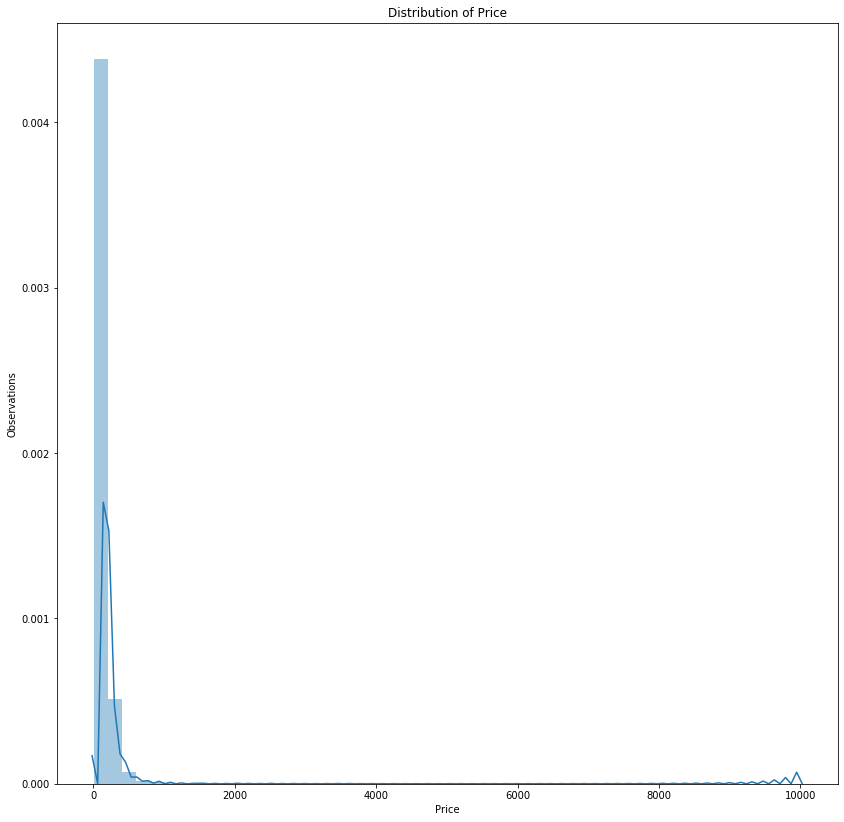

In [101]:
plt.figure(figsize = (14,14))
sns.distplot(df['price'], norm_hist = True)

plt.title('Distribution of Price')
# Set x-axis label
plt.xlabel('Price')
# Set y-axis label
plt.ylabel('Observations')

Text(0, 0.5, 'Observations')

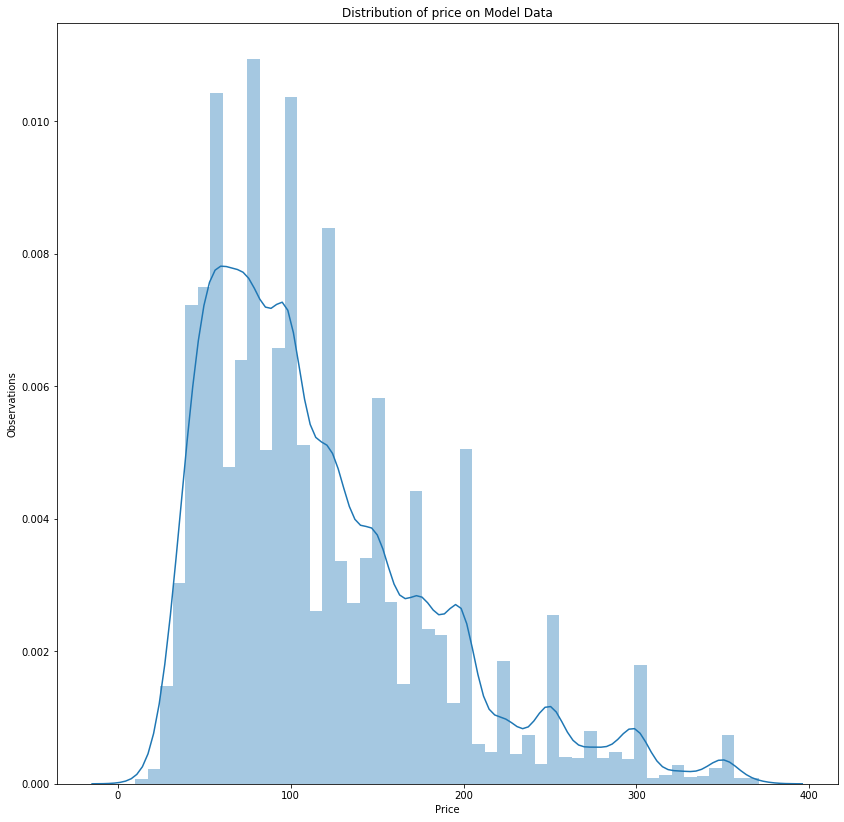

In [102]:
plt.figure(figsize = (14,14))
sns.distplot(model_df['price'])

plt.title('Distribution of price on Model Data')
# Set x-axis label
plt.xlabel('Price')
# Set y-axis label
plt.ylabel('Observations')

Text(0, 0.5, 'Observations')

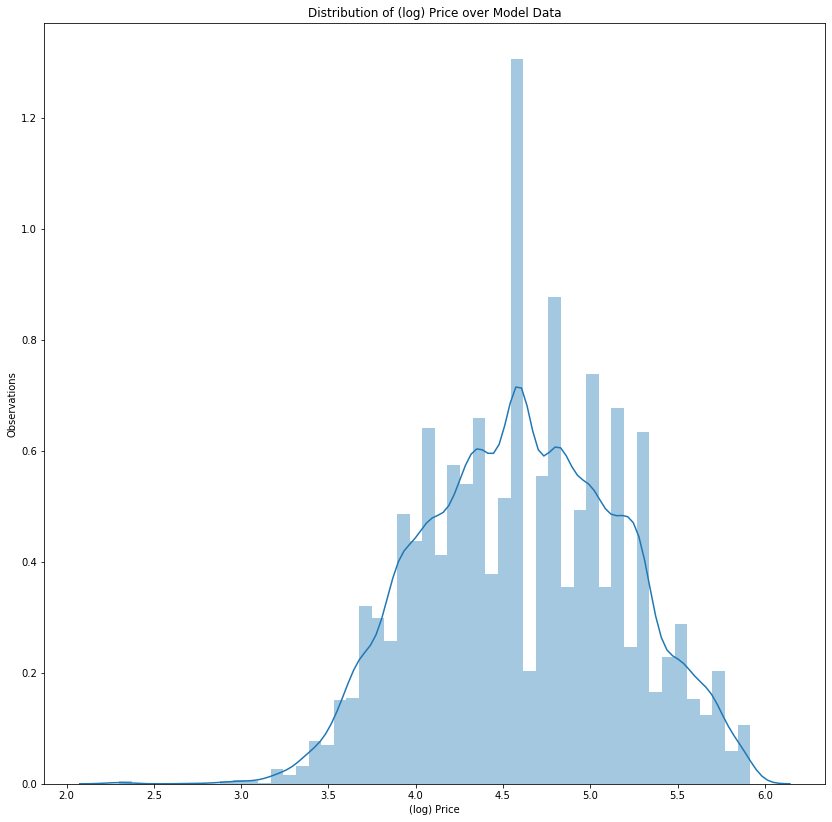

In [103]:
plt.figure(figsize = (14,14))
sns.distplot(model_df['log_price'])

plt.title('Distribution of (log) Price over Model Data')
# Set x-axis label
plt.xlabel('(log) Price')
# Set y-axis label
plt.ylabel('Observations')

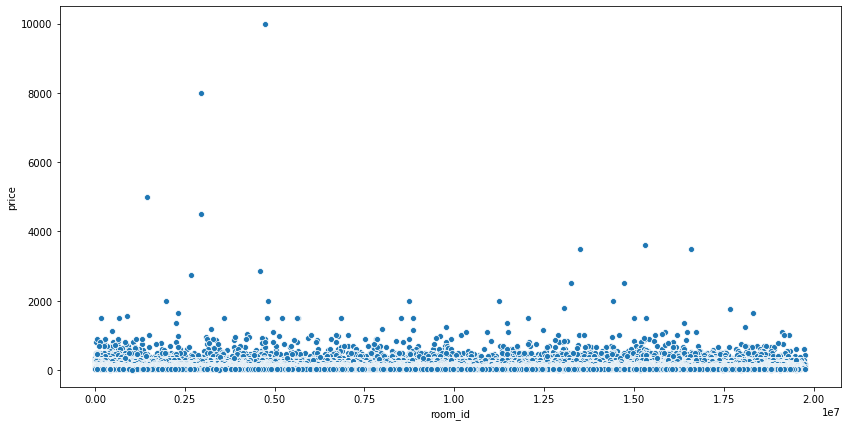

In [44]:
plt.figure(figsize = (14,7))
sns.scatterplot(data = df, x = df['room_id'], y = df['price'])

Text(0.5, 1, 'Correlation Heatmap')

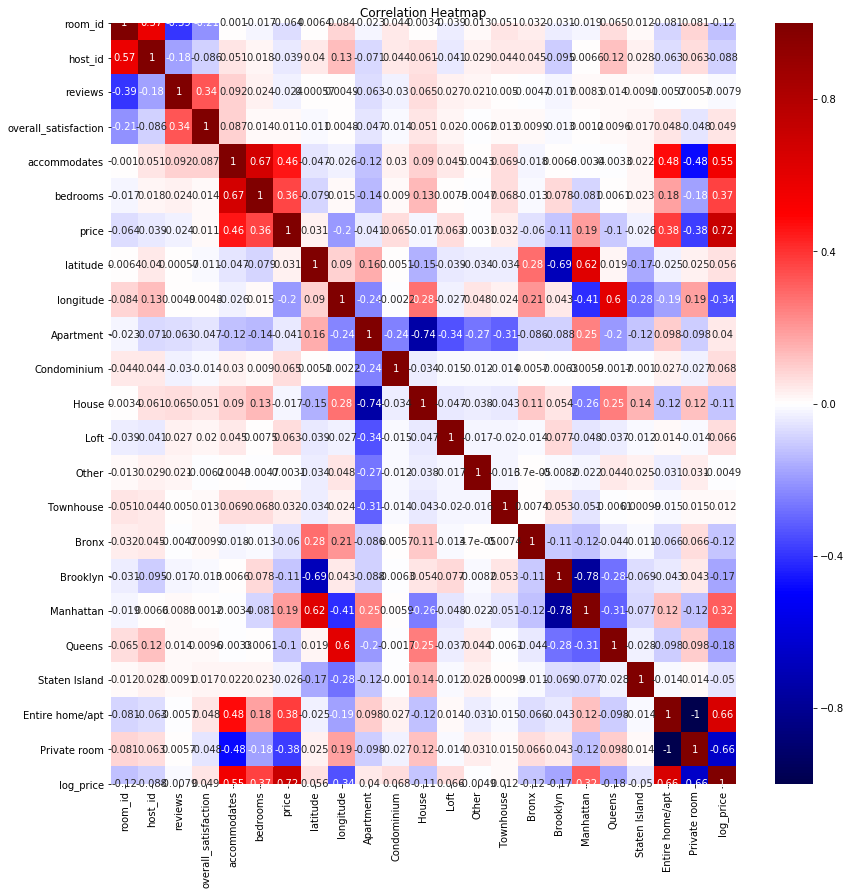

In [104]:
# Heatmap correlation
plt.figure(figsize = (14,14))
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

plt.title('Correlation Heatmap')



Text(0, 0.5, 'Price')

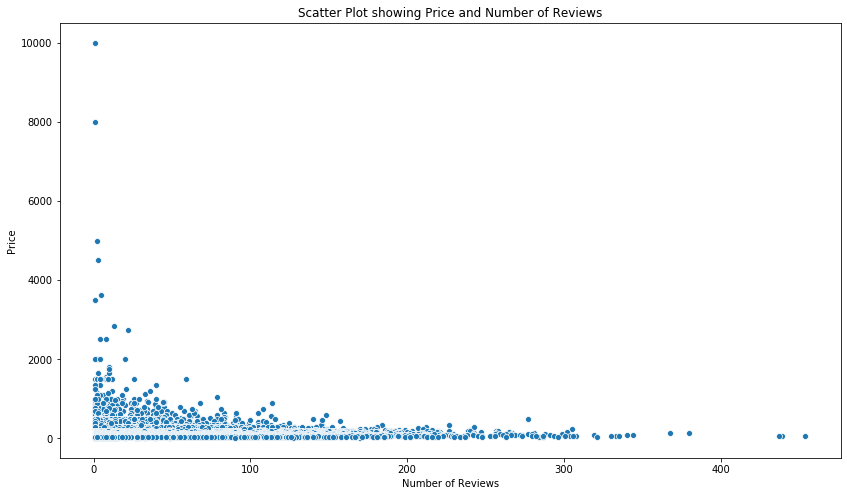

In [105]:
plt.figure(figsize = (14,8))
sns.scatterplot(data = df, x = df['reviews'], y = df['price'])

plt.title('Scatter Plot showing Price and Number of Reviews')
# Set x-axis label
plt.xlabel('Number of Reviews')
# Set y-axis label
plt.ylabel('Price')

Skewness: 0.434114
Kurtosis: 0.718808


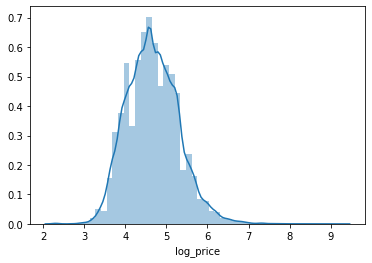

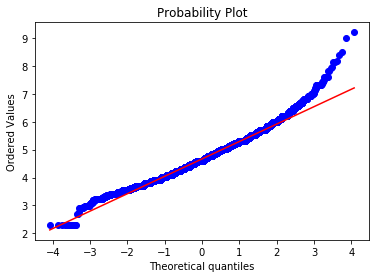

In [46]:
# plot log price of dataframe
sns.distplot(df['log_price'], kde=True,);
fig = plt.figure()
res = stats.probplot(df['log_price'], plot=plt)
print("Skewness: %f" % df['log_price'].skew())
print("Kurtosis: %f" % df['log_price'].kurt())
plt.title('(log) Price of Data Frame with ')

Skewness: -0.034736
Kurtosis: -0.492592


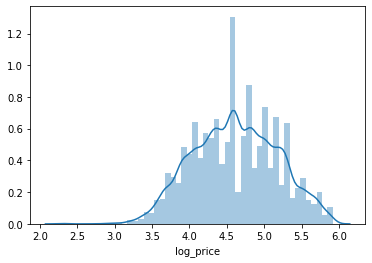

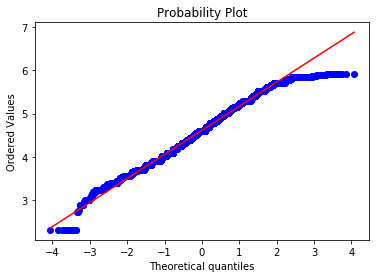

In [47]:
# plot log price of model dataframe
sns.distplot(model_df['log_price'], kde=True,);
fig = plt.figure()
res = stats.probplot(model_df['log_price'], plot=plt)
print("Skewness: %f" % model_df['log_price'].skew())
print("Kurtosis: %f" % model_df['log_price'].kurt())

Text(0.5, 1.0, 'Density and Distribution of prices for each Borough')

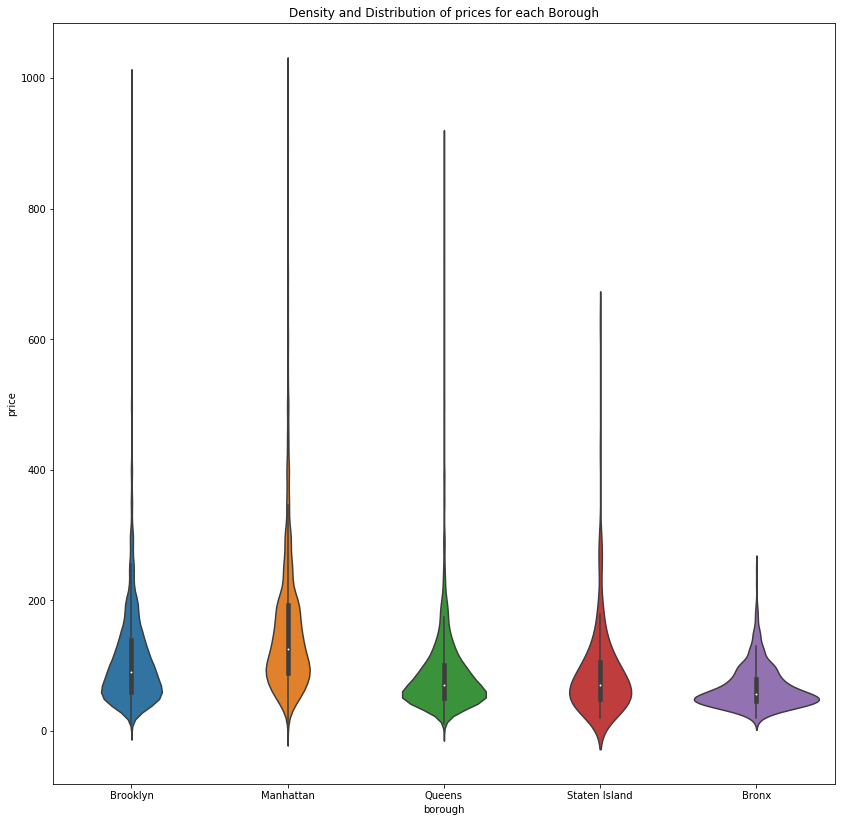

In [115]:
sdf = df[df.price < 1000]

plt.figure(figsize = (14,14))
nb_dens_plot = sns.violinplot(data=sdf, x='borough', y='price')
nb_dens_plot.set_title('Density and Distribution of prices for each Borough')


Text(0, 0.5, 'Price')

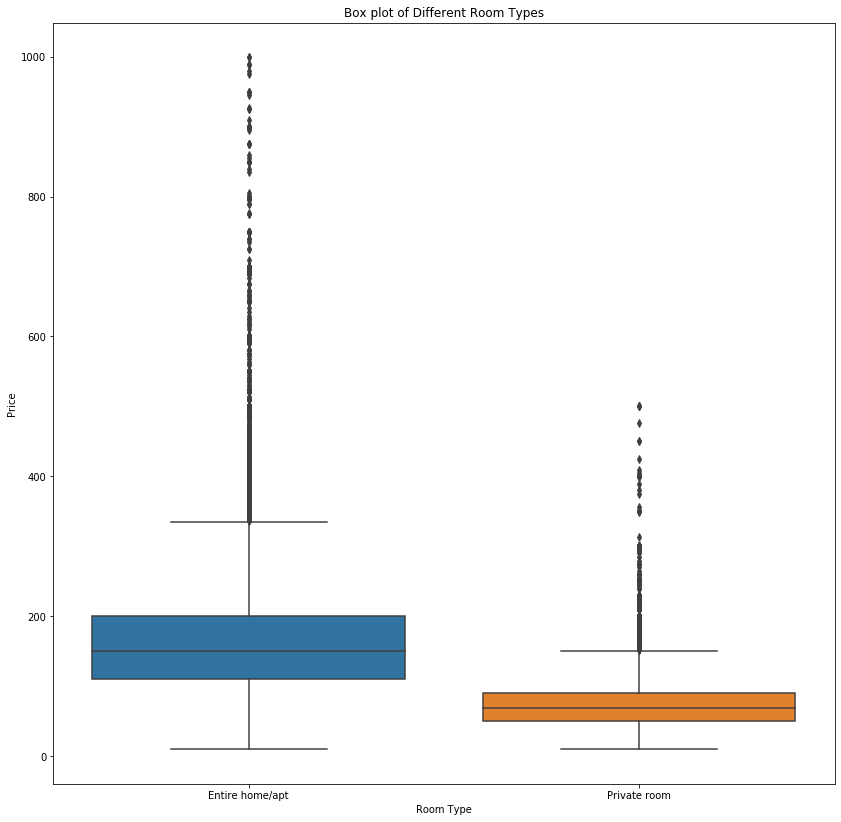

In [106]:
plt.figure(figsize = (14,14))
sns.boxplot(data = sdf, x = 'room_type', y = 'price')

plt.title('Box plot of Different Room Types')
# Set x-axis label
plt.xlabel('Room Type')
# Set y-axis label
plt.ylabel('Price')

In [50]:
df['Map'] = df['price'].apply(lambda x: 'Luxury' if x > 1000
                                                    else ('Premium' if x >= 500 and x < 1000
                                                          else('Affordable' if x >= 200 and x < 500
                                                               else('Economic'))))
                                                                    

Text(0, 0.5, 'Latitude')

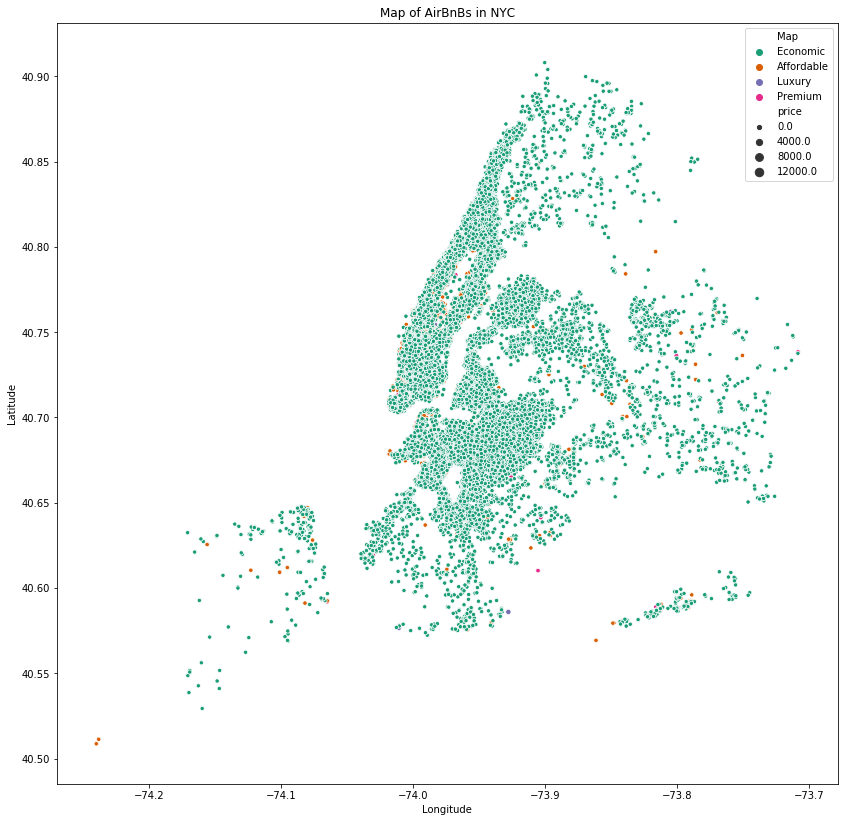

In [108]:
plt.figure(figsize = (14,14))


sns.scatterplot(df.longitude, df.latitude, hue='Map', size = 'price', 
                data= df, palette = "Dark2", hue_order = ['Economic', 'Affordable', 'Luxury', 'Premium'])
plt.title('Map of AirBnBs in NYC')
# Set x-axis label
plt.xlabel('Longitude')
# Set y-axis label
plt.ylabel('Latitude')

<Figure size 1008x1008 with 0 Axes>

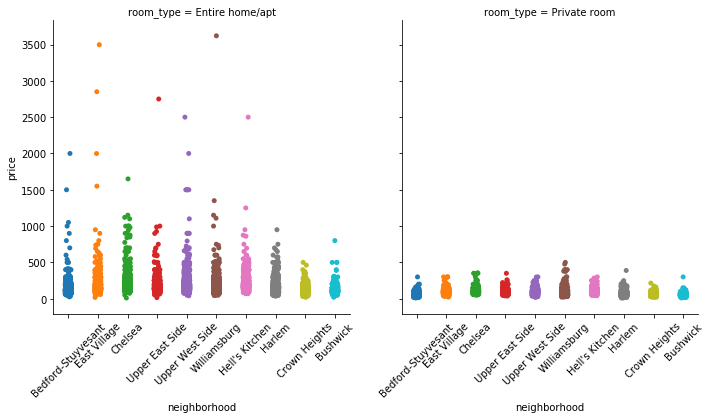

In [110]:
plt.figure(figsize = (14,14))
nbplot = sns.catplot(x='neighborhood', y = 'price', col= 'room_type', data =top10nb_df)
nbplot.set_xticklabels(rotation=45)

# Hypothesis Testing

## Hypothesis 1

In [53]:
# NH
# AH
# ANOVA 5 boros
# Multiple comparison test
# boros vs each other
# p values for each one

In [54]:
# H0: There is no difference between price in the five boroughs
# H1: There is a significant difference in price betwee the five boroughs



Text(0.5, 1.0, 'Density and Distribution of prices (log) for each Borough')

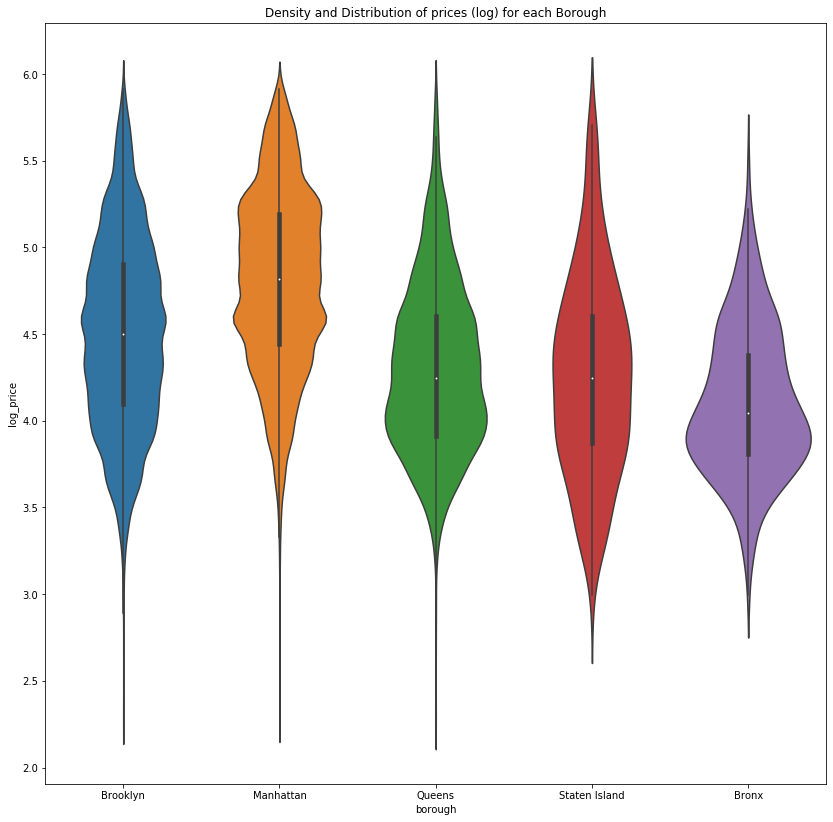

In [112]:
plt.figure(figsize = (14,14))
nb_dens_plot = sns.violinplot(data=model_df, x='borough', y='log_price')
nb_dens_plot.set_title('Density and Distribution of prices (log) for each Borough')

In [73]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [74]:
anova_boroughs = ols('log_price~borough', data=model_df).fit()
anova_boroughs

In [75]:
anova_table = sm.stats.anova_lm(anova_boroughs, type=2)
print(anova_table)

               df       sum_sq     mean_sq           F  PR(>F)
borough       4.0  1053.566143  263.391536  945.538233     0.0
Residual  29626.0  8252.693933    0.278563         NaN     NaN


In [76]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [77]:
mc = MultiComparison(model_df['log_price'], model_df['borough'])
mc_results = mc.tukeyhsd()
print(mc_results)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2    meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
    Bronx      Brooklyn   0.3993  0.001  0.3345   0.464   True
    Bronx     Manhattan   0.6939  0.001  0.6293  0.7586   True
    Bronx        Queens   0.2032  0.001  0.1346  0.2718   True
    Bronx Staten Island   0.1557 0.0033  0.0368  0.2746   True
 Brooklyn     Manhattan   0.2946  0.001  0.2767  0.3126   True
 Brooklyn        Queens  -0.1961  0.001 -0.2253 -0.1669   True
 Brooklyn Staten Island  -0.2435  0.001 -0.3449 -0.1422   True
Manhattan        Queens  -0.4907  0.001 -0.5197 -0.4618   True
Manhattan Staten Island  -0.5382  0.001 -0.6395 -0.4369   True
   Queens Staten Island  -0.0475 0.6982 -0.1514  0.0564  False
--------------------------------------------------------------


In [78]:
mc_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Bronx,Brooklyn,0.3993,0.001,0.3345,0.464,True
Bronx,Manhattan,0.6939,0.001,0.6293,0.7586,True
Bronx,Queens,0.2032,0.001,0.1346,0.2718,True
Bronx,Staten Island,0.1557,0.0033,0.0368,0.2746,True
Brooklyn,Manhattan,0.2946,0.001,0.2767,0.3126,True
Brooklyn,Queens,-0.1961,0.001,-0.2253,-0.1669,True
Brooklyn,Staten Island,-0.2435,0.001,-0.3449,-0.1422,True
Manhattan,Queens,-0.4907,0.001,-0.5197,-0.4618,True
Manhattan,Staten Island,-0.5382,0.001,-0.6395,-0.4369,True
Queens,Staten Island,-0.0475,0.6982,-0.1514,0.0564,False


In [ ]:
# Majority of the Boros have a low p-value so we reject the null hypothesis 
# except between Staten Island and Queens where we fail to reject the null hypothesis

## Hypothesis Test 2

In [ ]:
# H0: There is no difference in log price between types of rooms.
# H1: There is a difference in log price between types of rooms.

Text(0.5, 1.0, 'Box Plot of (log) Price Based on Room Type')

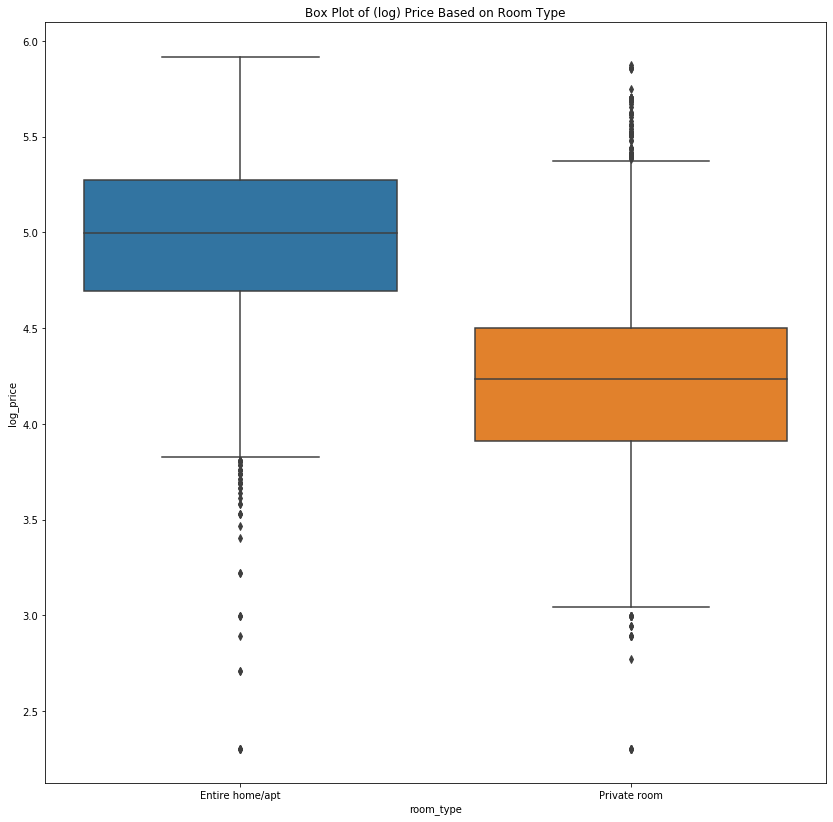

In [113]:
plt.figure(figsize = (14,14))
sns.boxplot(data = model_df, x = 'room_type', y = 'log_price')
plt.title('Box Plot of (log) Price Based on Room Type')

In [82]:
from scipy.stats import ttest_ind
import numpy as np

In [85]:
ttest_ind(model_df['Entire home/apt'] , model_df['Private room'], equal_var = False)

Ttest_indResult(statistic=8.162586031269566, pvalue=3.3430794434736194e-16)

In [ ]:
# The value is extremely low so we reject the null hypothesis and there is a significant difference between room types

# Model Development

In [56]:
model_df.dtypes

room_id                   int64
host_id                   int64
room_type                object
city                     object
borough                  object
neighborhood             object
reviews                   int64
overall_satisfaction    float64
accommodates              int64
bedrooms                float64
price                   float64
property_type            object
latitude                float64
longitude               float64
Apartment                 uint8
Condominium               uint8
House                     uint8
Loft                      uint8
Other                     uint8
Townhouse                 uint8
Bronx                     uint8
Brooklyn                  uint8
Manhattan                 uint8
Queens                    uint8
Staten Island             uint8
Entire home/apt           uint8
Private room              uint8
log_price               float64
borough_cat              object
dtype: object

In [57]:
model_df.corr()['log_price'].sort_values()

Private room           -0.669636
longitude              -0.336890
Queens                 -0.181974
Brooklyn               -0.159503
House                  -0.151351
room_id                -0.129107
Bronx                  -0.119837
host_id                -0.104894
Staten Island          -0.052013
Townhouse              -0.008201
Other                  -0.007395
reviews                 0.006649
Loft                    0.038053
Condominium             0.042592
latitude                0.054924
overall_satisfaction    0.057688
Apartment               0.101042
bedrooms                0.260545
Manhattan               0.308809
accommodates            0.488104
Entire home/apt         0.669636
price                   0.948867
log_price               1.000000
Name: log_price, dtype: float64

In [58]:
X = model_df[["Entire home/apt", "bedrooms","Manhattan" ,"bedrooms" ,"Condominium" ,"Loft" ,"Townhouse","latitude","accommodates","overall_satisfaction"]]     
y = model_df['log_price']

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
X, X_test, y, y_test = train_test_split(X, y, test_size=.2)

In [60]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25)

In [61]:
#set up the 3 models we're choosing from:
lm = LinearRegression()
#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)
lm_reg = Ridge(alpha=1)
#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 
X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)
lm_poly = LinearRegression()

In [62]:
#validate
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')
lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.578
Ridge Regression val R^2: 0.578
Degree 2 polynomial regression val R^2: 0.628


In [63]:
predictions = lm.predict(X_test)
predictions

array([4.42781477, 4.90791601, 4.08866433, ..., 4.44055167, 4.84377579,
       4.23257294])

In [64]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.579


Text(0.5, 1.0, 'Comparison between True Values and Predicted Values')

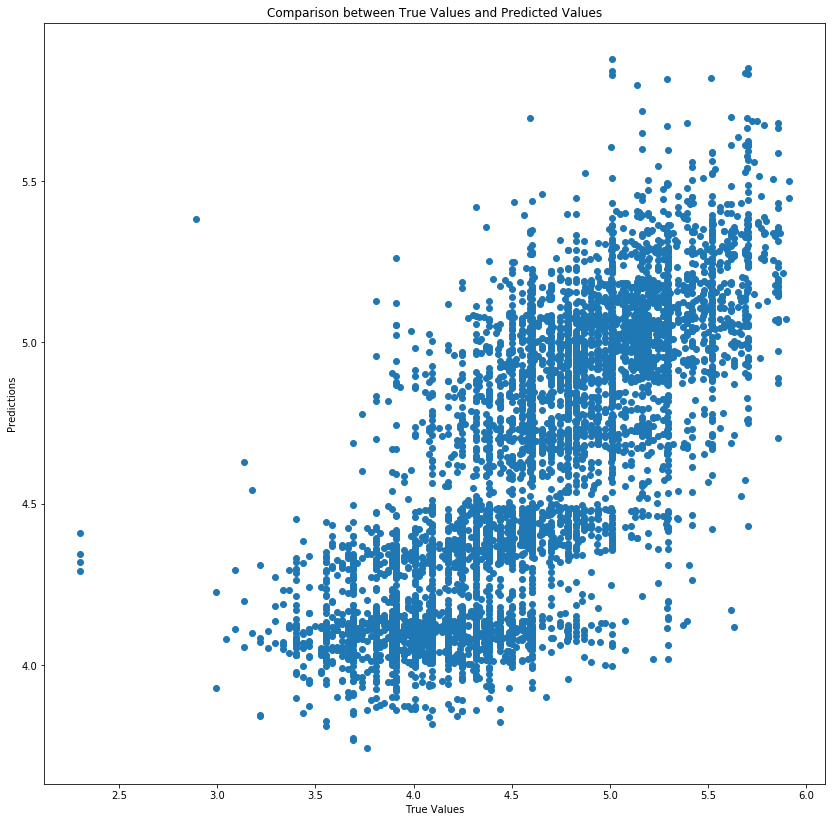

In [114]:
plt.figure(figsize = (14,14))
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.title('Comparison between True Values and Predicted Values')


# Cross Validation


In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


lm = LinearRegression()
cross_val_score(lm, X, y, # estimator, features, target
                cv=3, # number of folds 
                scoring='r2') # scoring metric

array([0.57014269, 0.57087976, 0.57291392])

In [67]:
kf = KFold(n_splits=5, shuffle=True)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([0.5749057 , 0.57720274, 0.54508271, 0.5790638 , 0.57906509])

In [68]:
kf = KFold(n_splits=5, shuffle=True)
print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))

0.5710411763919822


In [69]:
# Low variance

## Results

Looking at the results, our model is able to predict the value of AirBnB rental with a R score of 0.578.

Iterating on the model and adjusting the price parameters, we chose to segment and remove part of the data. For some reason, the data set contained a large concentration of zeros for price which is not helpful in creating a tool. Even though there is quite a bit of noise between the True Values and the Predicted Values, our model scores are very close. This means the model has very low variance. 

Coefficients with the largest impact:

Accomodation Size had the highest correlation with price, this intuitively makes sense as larger bookings usually come at a higher cost.

Prices vary between Boroughs. Brooklyn and Manhattan are the most popular and therefore tend to be more expensive while Queens and Staten Island were the cheapest.

Offering an Entire House instead of just a private room demonstrated higher prices.


# Conlcusion

The purpose of this project was to be able to predict the price of an accomodation for a night in New York City through AirBnB. While the debate has mostly gone away, this model can be used to entice landowners into using AirBnB to book short term rentals and help them choose a price per night. 

But after going through all of the data we notice that there were some shortcomings. The model isn't going to be great at predicting 'new' rentals to the market. Some of the points we cut out were listings that had zero reviews. Also, the model has included geographic position data but does not include competitive information such as proximity to entertainment or grocery stores. 

A more complete data set would yield better results, however for a first iteration, we propose the above shown models.